## Imports

In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image
from copy import deepcopy


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from utils import *

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance 
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression


import warnings
warnings.filterwarnings('ignore')




# Part 1

## Load Data

In [82]:
# Data paths
labeled_data_path = '../data/data_labeled/'
unlabeled_data_path = '../data/data_unlabeled/'

# Image paths
img_test_unlabeled_path = '../data/data_labeled/Img_test/'
img_train_unlabeled_path = '../data/data_labeled/Img_train/'
X_img_path = '../data/data_unlabeled/Img/'

# Load csv's
X_test = pd.read_csv(labeled_data_path + 'X_test.csv')
X_train = pd.read_csv(labeled_data_path + 'X_train.csv')
y_test = pd.read_csv(labeled_data_path + 'y_test.csv', header=None)
y_train = pd.read_csv(labeled_data_path + 'y_train.csv', header=None)
X_unlabeled = pd.read_csv(unlabeled_data_path + 'X.csv')

X_test.head()

,age,blood pressure,calcium,cholesterol,hemoglobin,height,potassium,profession,sarsaparilla,smurfberry liquor,smurfin donuts,vitamin D,weight,img_filename
0,85,106.92,2.25,120.85,14.90,7.41,3.26,resource extraction,Low,High,Moderate,36.27,93.20,heart_0.png
1,130,94.73,2.61,121.74,16.88,7.53,4.74,manufacturing,Very high,Very high,Moderate,25.97,105.24,heart_6.png
2,180,110.31,2.47,75.35,15.52,8.02,4.29,manufacturing,High,Moderate,Very low,37.53,100.61,heart_7.png
3,78,95.46,2.28,125.30,11.68,7.75,4.17,services,Very low,Low,Moderate,28.19,103.94,heart_10.png
4,116,106.13,2.11,89.98,14.83,7.89,4.73,resource extraction,Low,Very high,Low,30.07,82.53,heart_11.png


## Preprocess Data

In [83]:

#Save data before cleaning
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()
X_unlabeled_clean = X_unlabeled.copy()

X_train = X_train.drop(columns=['img_filename'])
X_test = X_test.drop(columns=['img_filename'])
X_unlabeled = X_unlabeled.drop(columns=['img_filename'])

X_train = pd.get_dummies(X_train, columns=['profession'])
X_test = pd.get_dummies(X_test, columns=['profession'])
X_unlabeled = pd.get_dummies(X_unlabeled, columns=['profession'])

# Ordinal encoding of consumption features
consumption_map = {
    'Very low': 1,
    'Low': 2,
    'Moderate': 3,
    'High': 4,
    'Very high': 5
}

for col in ['sarsaparilla', 'smurfberry liquor', 'smurfin donuts']:
    X_train[col] = X_train[col].map(consumption_map)
    X_test[col] = X_test[col].map(consumption_map)
    X_unlabeled[col] = X_unlabeled[col].map(consumption_map)
    
# Standardize numerical features
numerical_features = [
    'age', 'blood pressure', 'calcium', 'cholesterol',
    'hemoglobin', 'height', 'potassium',
    'vitamin D', 'weight'
]

X_train_original = X_train.copy()
X_test_original = X_test.copy()
X_unlabeled_original = X_unlabeled.copy()


## Feature Selection

### Filter

#### Mutual Information

In [84]:

mi_scores = mutual_info_regression(X_train, y_train.values.ravel(), random_state=42)
mi_df = pd.DataFrame({'Feature': X_train.columns, 'MI': mi_scores})
mi_df = mi_df.sort_values(by='MI', ascending=False).reset_index(drop=True)


mean_mi, std_mi = mi_df['MI'].mean(), mi_df['MI'].std()

threshold_soft = mean_mi + 0.3 * std_mi
selected_by_threshold = mi_df[mi_df['MI'] > threshold_soft]['Feature'].tolist()
print(len(selected_by_threshold))
# En cas de peu de sélection, garde toutes les features avec MI > 0
if len(selected_by_threshold) < 6:
    selected_by_threshold = mi_df[mi_df['MI'] > 0]['Feature'].tolist()

print(f"\n Seuil souple = {threshold_soft:.4f}")
print(f"{len(selected_by_threshold)} features retenues après filtrage MI :")
print(selected_by_threshold)

# Sous-ensembles correspondants
selected_features_mi = selected_by_threshold
X_train_mi = X_train[selected_features_mi].copy()
X_test_mi  = X_test[selected_features_mi].copy()
X_unlabeled_mi = X_unlabeled[selected_features_mi].copy()

4

 Seuil souple = 0.0610
14 features retenues après filtrage MI :
['blood pressure', 'cholesterol', 'weight', 'smurfin donuts', 'potassium', 'sarsaparilla', 'vitamin D', 'profession_administration and governance', 'age', 'hemoglobin', 'profession_services', 'profession_food production', 'profession_resource extraction', 'profession_manufacturing']


#### Maximum relevance and minimum redundancy

In [85]:
corr_matrix = X_train_mi.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [col for col in upper.columns if any(upper[col] > 0.85)]
X_train_mrmr = X_train_mi.drop(columns=high_corr, errors='ignore')
#X_val_mrmr = X_val_mi.drop(columns=high_corr, errors='ignore')
X_test_mrmr = X_test_mi.drop(columns=high_corr, errors='ignore')
X_unlabeled_mrmr = X_unlabeled_mi.drop(columns=high_corr, errors='ignore')
y_train_ravel = y_train.values.ravel()
print(f"\n{len(high_corr)} variables redondantes supprimées après mRMR simplifié :")
print(high_corr)
print(f"{X_train_mrmr.shape[1]} features restantes après mRMR.")


0 variables redondantes supprimées après mRMR simplifié :
[]
14 features restantes après mRMR.


#### RF selection

In [86]:

rf_selector = RandomForestRegressor(n_estimators=100, random_state =42, n_jobs=-1)
rf_selector.fit(X_train_mrmr, y_train_ravel)

importances = rf_selector.feature_importances_
feature_names = X_train_mrmr.columns
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 des caractéristiques selon Random Forest Importance:")
print(feature_importances_df.head(10))


Top 10 des caractéristiques selon Random Forest Importance:
                           Feature  Importance
0                   blood pressure    0.581197
9                       hemoglobin    0.117307
4                        potassium    0.098481
2                           weight    0.044934
8                              age    0.043431
1                      cholesterol    0.039196
6                        vitamin D    0.027567
5                     sarsaparilla    0.019582
3                   smurfin donuts    0.010945
12  profession_resource extraction    0.004388


In [87]:


linreg_final = LinearRegression()
linreg_final.fit(X_train_mrmr, y_train)

y_pred_test = linreg_final.predict(X_test_mrmr)
rmse_test_linear = compute_rmse(y_pred_test, y_test)
print(f"\nRMSE sur test = {rmse_test_linear:.4f}")

# Prédictions
y_pred_unlabeled = linreg_final.predict(X_unlabeled_mrmr)


print("\nFichier y_pred.csv généré avec succès !")


RMSE sur test = 0.0571

Fichier y_pred.csv généré avec succès !


# Part 2

In [88]:
rmse_scorer_for_rfecv = make_scorer(compute_rmse, greater_is_better=False)
rf_estimator = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
print("Début de la sélection de caractéristiques RFECV (Cross-Validation) en utilisant la RMSE...")
rfecv_selector = RFECV(
    estimator=rf_estimator,
    step=1,
    cv=5,                             # Utilise 5 plis de Cross-Validation
    scoring=rmse_scorer_for_rfecv,    # Utilisation de votre RMSE scorer
    n_jobs=-1,
    verbose=1
)
rfecv_selector.fit(X_train_mrmr, y_train_ravel)

N_optimal = rfecv_selector.n_features_
print(f"\nNombre optimal de caractéristiques (N) déterminé par CV : {N_optimal}")
selected_features_rfecv = X_train_mrmr.columns[rfecv_selector.support_].tolist()
print("\nCaractéristiques sélectionnées :")
print(selected_features_rfecv)

X_train_part2 = X_train_mrmr[selected_features_rfecv].copy()
X_test_part2 = X_test_mrmr[selected_features_rfecv].copy()

Début de la sélection de caractéristiques RFECV (Cross-Validation) en utilisant la RMSE...
Fitting estimator with 14 features.
Fitting estimator with 14 features.
Fitting estimator with 14 features.
Fitting estimator with 14 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 13 features.
Fitting estimator with 13 features.
Fitting estimator with 13 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting e

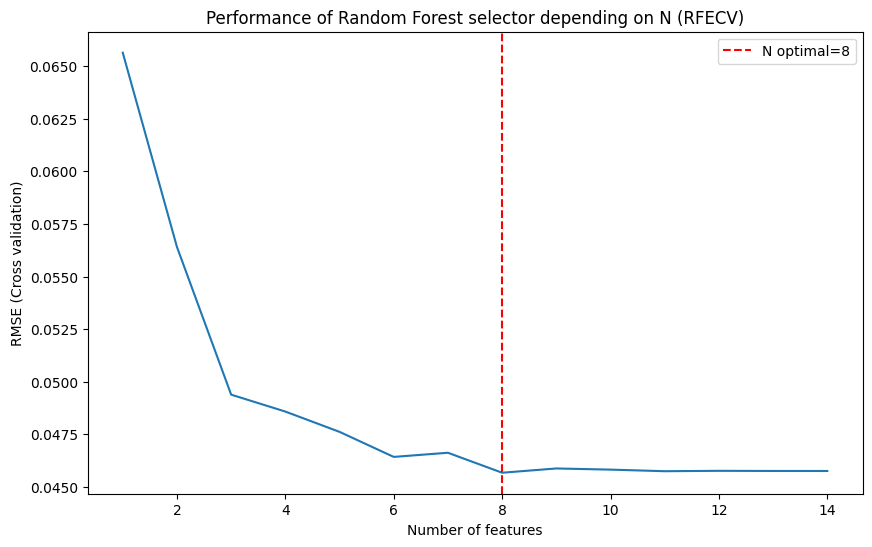

In [89]:

# Assuming it returns the actual RMSE values (since greater_is_better=False)
scores_rmse = -rfecv_selector.cv_results_['mean_test_score'] 
n_features_range = range(1, len(X_train_mrmr.columns) + 1)

# Création du graphique (nécessite matplotlib)
plt.figure(figsize=(10, 6))
plt.plot(n_features_range, scores_rmse)
plt.xlabel("Number of features")
plt.ylabel("RMSE (Cross validation)")
plt.title("Performance of Random Forest selector depending on N (RFECV)")
plt.axvline(x=N_optimal, color='r', linestyle='--', label=f'N optimal={N_optimal}')
plt.legend()
#plt.savefig("C:/Users/User/Desktop/GBIOM2/LELEC2870_Machine_learning/LELEC2870-Project/plots/performance_rf_selection.pdf")
plt.show()


--- Optimisation du MLP (Simple) ---

--- Optimisation du Multi-Layer Perceptron (MLP) ---
Début du tuning MLP...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 60), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.1s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 60), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.1s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 60), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.1s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 60), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.1s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(200, 120), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.3s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(200, 120), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.3s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(200, 120), mlp__lea

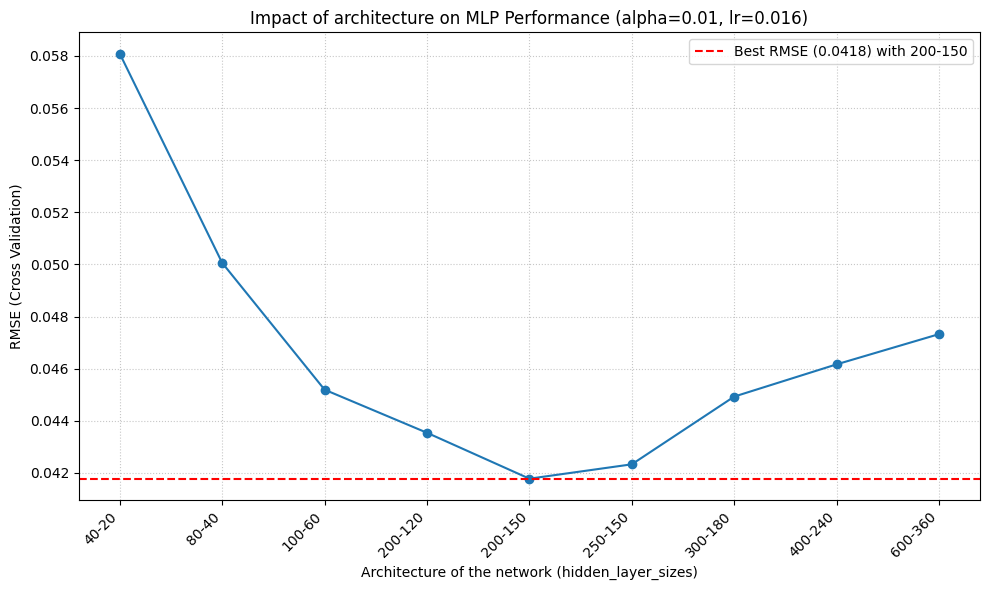

In [90]:
print("\n--- Optimisation du MLP (Simple) ---")

mlp_base_estimator = MLPRegressor(max_iter=500, random_state=42)

# Créer le Pipeline : Scaling puis MLP
pipe_mlp_fine_tune = Pipeline([
    ('scaler', StandardScaler()), 
    ('mlp', mlp_base_estimator) 
])
param_grid_mlp_final = {
    # Architectures à tester :
    # Essayer des configurations à 1 ou 2 couches
    # (40,) : 1 couche de 40 neurones (assez petite pour 12 features)
    # (40, 20) : 2 couches (40 puis 20)
    # (80, 40) : 2 couches plus larges
    'mlp__hidden_layer_sizes': [(40,20), (80, 40), (100, 60), (200, 120),(200,150), (250, 150),(300, 180),(400, 240), (600, 360)], 
    
    # Fonction d'activation (ReLU est standard et performante)
    'mlp__activation': ['relu'],
    
    # Terme de régularisation L2 (alpha)
    # Le MLP est sensible à l'overfitting, donc il faut tester la régularisation
    'mlp__alpha': [0.01],
    
    # Taux d'apprentissage initial
    'mlp__learning_rate_init': [0.016], 
    
    'mlp__solver': ['adam']
}
#Meilleurs hyperparamètres MLP : {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (400, 240), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
# Fixer le nombre maximum d'itérations
# max_iter doit être suffisant pour que le réseau converge (souvent 500 ou 1000)
#mlp_estimator_final = MLPRegressor(max_iter=500, random_state=42)

mlp_grid_final = GridSearchCV(
    estimator=pipe_mlp_fine_tune,
    param_grid=param_grid_mlp_final,
    scoring=rmse_scorer_for_rfecv, # Utilisation du scorer RMSE négatif
    cv=5,
    n_jobs=-1,
    verbose=2
)

print("\n--- Optimisation du Multi-Layer Perceptron (MLP) ---")
print("Début du tuning MLP...")

# Entraînement et tuning sur les 12 caractéristiques
mlp_grid_final.fit(X_train_part2, y_train_ravel) 

# Extraction du résultat RMSE réel (inversion du signe)
best_rmse_val_mlp_final = -mlp_grid_final.best_score_ 

print(f"\nMeilleur RMSE (Validation Croisée MLP) : {best_rmse_val_mlp_final:.4f}")
print(f"Meilleurs hyperparamètres MLP : {mlp_grid_final.best_params_}")

# Sauvegarder le meilleur modèle pour la comparaison finale
best_mlp_model_final = mlp_grid_final.best_estimator_


import pandas as pd


# Assurez-vous d'utiliser l'objet mlp_grid après le fit final
results = pd.DataFrame(mlp_grid_final.cv_results_)

# Création d'une clé d'architecture simple pour le graphique
# Nous allons simplifier l'affichage du tuple (ex: (80, 40) devient '80-40')
def format_architecture(hls_tuple):
    if isinstance(hls_tuple, tuple):
        return '-'.join(map(str, hls_tuple))
    return str(hls_tuple)

results['Architecture_str'] = results['param_mlp__hidden_layer_sizes'].apply(format_architecture)

# Filtrer uniquement les résultats avec les meilleurs autres hyperparamètres 
# (activation='relu', alpha=0.015, learning_rate_init=0.015, solver='adam') 
# pour isoler l'effet de la taille des couches.

best_alpha = mlp_grid_final.best_params_['mlp__alpha']
best_lr = mlp_grid_final.best_params_['mlp__learning_rate_init']

filtered_results = results[
    (results['param_mlp__alpha'] == best_alpha) & 
    (results['param_mlp__learning_rate_init'] == best_lr) &
    (results['param_mlp__activation'] == 'relu') # Si vous n'avez testé que 'relu'
].copy()

# Calcul du RMSE réel (inverser le signe du score CV)
results['RMSE_CV'] = -results['mean_test_score']
plt.figure(figsize=(10, 6))

# Création du graphique : Architecture (X) vs RMSE (Y)
plt.plot(
    results['Architecture_str'], 
    results['RMSE_CV'], 
    marker='o', 
    linestyle='-', 
    color='#1f77b4'
)

# Marquage du meilleur score
min_rmse = results['RMSE_CV'].min()
best_arch = results.loc[results['RMSE_CV'].idxmin(), 'Architecture_str']
plt.axhline(y=min_rmse, color='r', linestyle='--', 
            label=f'Best RMSE ({min_rmse:.4f}) with {best_arch}')

plt.xlabel("Architecture of the network (hidden_layer_sizes)")
plt.ylabel("RMSE (Cross Validation)")
plt.title(f"Impact of architecture on MLP Performance (alpha={best_alpha}, lr={best_lr})")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Le score de généralisation final est du pour le mlp est : 0.0428


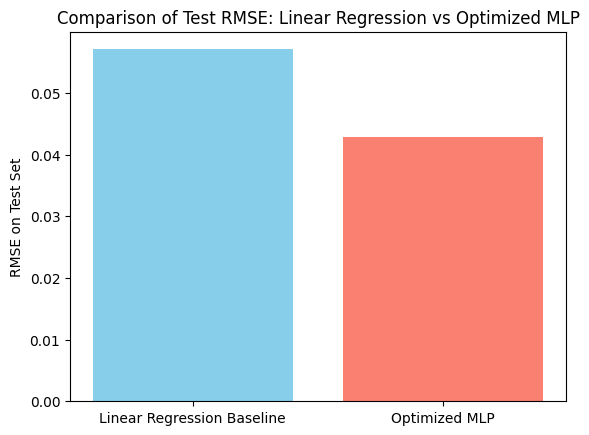

In [91]:

# Prédictions sur l'ensemble de Test
y_test_ravel = y_test.values.ravel() if hasattr(y_test, 'values') else y_test.ravel()
y_pred_test_mlp = best_mlp_model_final.predict(X_test_part2)

# Calcul des RMSE de Test
rmse_test_mlp = compute_rmse(y_pred_test_mlp, y_test_ravel)

# Modèle Linéaire (Baseline - Valeur obtenue en Partie 1)
linearBaseline = rmse_test_linear

# --- 3. Synthèse des Résultats Finals ---

#plot difference in test RMSE
print(f"Le score de généralisation final est du pour le mlp est : {rmse_test_mlp:.4f}")
labels = ['Linear Regression Baseline', 'Optimized MLP']
rmse_values = [linearBaseline, rmse_test_mlp]
plt.bar(labels, rmse_values, color=['skyblue', 'salmon'])
plt.ylabel('RMSE on Test Set')
plt.title('Comparison of Test RMSE: Linear Regression vs Optimized MLP')
plt.show()  

# Part3

Samples: 1000 | Tabular dims: 9 | Images: 1000
Train: (800, 9), Test: (200, 9)
t-SNE on pixel values


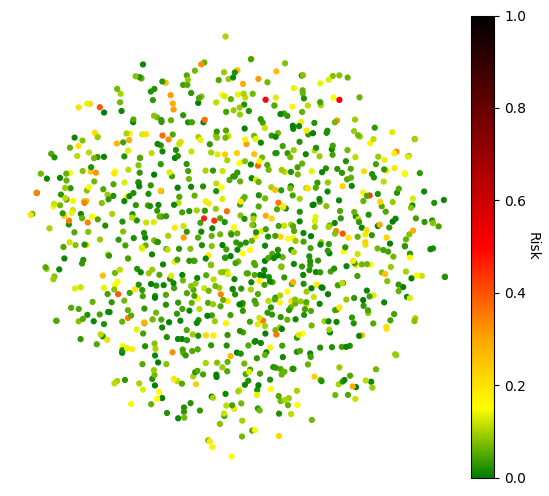

In [92]:


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
X_df = pd.read_csv("../data/data_labeled/X_train.csv")
y_df = pd.read_csv("../data/data_labeled/y_train.csv", header=None, names=["risk"])

assert "img_filename" in X_df.columns, "Expected column 'img_filename' in X_train.csv"

# Separate image filenames and tabular features
img_filenames = X_df["img_filename"].astype(str).values
X_tabular = X_df.drop(columns=["img_filename"])

# Keep only numeric columns to feed MLP
X_tabular = X_tabular.select_dtypes(include=[np.number])

y = y_df["risk"].values.reshape(-1)

print(f"Samples: {len(X_df)} | Tabular dims: {X_tabular.shape[1]} | Images: {len(img_filenames)}")

# Train/test split (aligned between tabular, images, and targets)
X_tab_train, X_tab_test, img_train, img_test, y_train, y_test = train_test_split(
    X_tabular.values, img_filenames, y, test_size=0.2, random_state=RANDOM_STATE, stratify=None
)

print(f"Train: {X_tab_train.shape}, Test: {X_tab_test.shape}")

dataset_viz = CustomImageDataset(
    images=img_filenames, 
    images_directory="../data/data_labeled/Img_train", 
    target=y
)
print("t-SNE on pixel values")
visualize_dataset_tSNE(dataset_viz, extract_features=False, perplexity=30, random_state=42, zoom=2.0)

Epoch  5 | Train RMSE: 0.0833 | Val RMSE: 0.0819
Epoch 10 | Train RMSE: 0.0763 | Val RMSE: 0.0778
Epoch 15 | Train RMSE: 0.0685 | Val RMSE: 0.0747
Epoch 20 | Train RMSE: 0.0623 | Val RMSE: 0.0760
Epoch 25 | Train RMSE: 0.0598 | Val RMSE: 0.0718
Epoch 30 | Train RMSE: 0.0565 | Val RMSE: 0.0717
Epoch 35 | Train RMSE: 0.0539 | Val RMSE: 0.0716
Epoch 40 | Train RMSE: 0.0515 | Val RMSE: 0.0721
Epoch 45 | Train RMSE: 0.0499 | Val RMSE: 0.0740
Epoch 50 | Train RMSE: 0.0516 | Val RMSE: 0.0739
Epoch 55 | Train RMSE: 0.0463 | Val RMSE: 0.0741
Epoch 60 | Train RMSE: 0.0457 | Val RMSE: 0.0748
Extracted image features:
Z_train: (800, 8) Z_test: (200, 8)


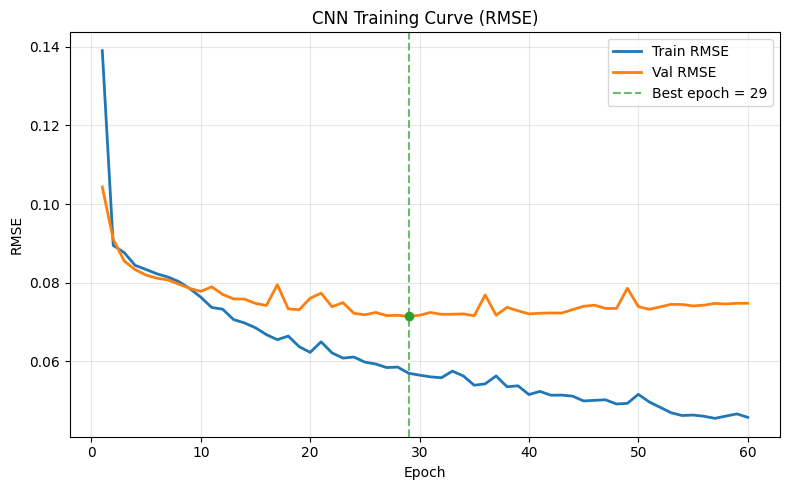

In [93]:
IMAGE_DIR = "../data/data_labeled/Img_train"
N_FEATURES = 8  # dimension of image-derived feature vector

cnn = MyCNN(n_features=N_FEATURES, n_epochs=60, batch_size=50, learning_rate=5e-4)
history = cnn.fit(images=img_train, y=y_train, data_dir=IMAGE_DIR)

# Extract features for train and test
Z_train = cnn.extract_features(images=img_train, data_dir=IMAGE_DIR)  # shape (n_train, N_FEATURES)
Z_test  = cnn.extract_features(images=img_test,  data_dir=IMAGE_DIR)  # shape (n_test,  N_FEATURES)

print("Extracted image features:")
print("Z_train:", Z_train.shape, "Z_test:", Z_test.shape)

plot_cnn_training_curves(
    history, 
    best_epoch=cnn.best_epoch, 
    best_val_rmse=cnn.best_val_rmse, 
    title="CNN Training Curve (RMSE)"
)


In [94]:
# Tabular-only baseline

rmse_tab_test = rmse_test_mlp 
print("Tabular-only MLP:")
print(f"  Test RMSE: {rmse_test_mlp:.4f}")

Tabular-only MLP:
  Test RMSE: 0.0428


t-SNE on extracted CNN features


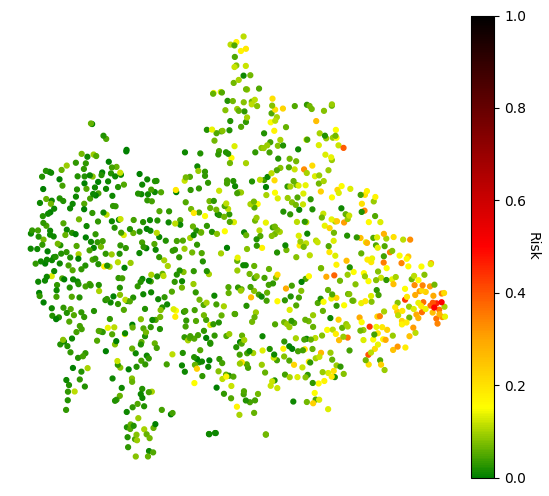

In [95]:
print("t-SNE on extracted CNN features")
visualize_dataset_tSNE(dataset_viz, extract_features=True, feature_extractor=cnn, perplexity=30, random_state=42, zoom=2.0)

Combined shapes: (800, 17) (200, 17)



Tabular + Image MLP:
  Test RMSE: 0.0397


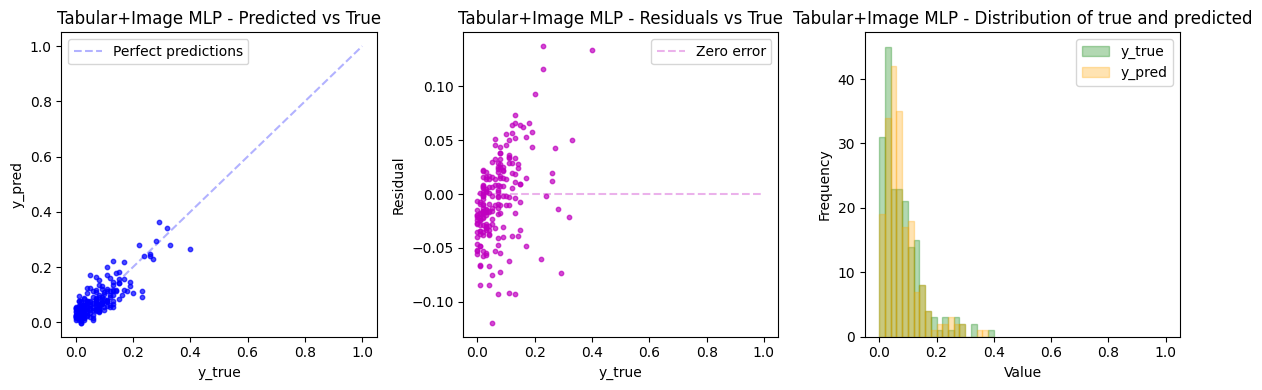

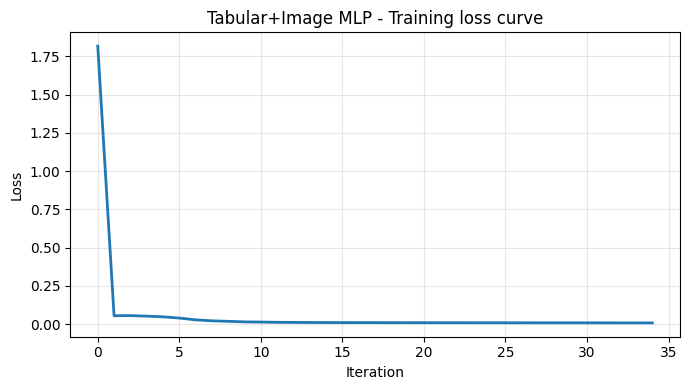

In [96]:
# Combine tabular and image features
X_comb_train = np.hstack([X_tab_train, Z_train])
X_comb_test  = np.hstack([X_tab_test,  Z_test])
print("Combined shapes:", X_comb_train.shape, X_comb_test.shape)

best_mlp_model_final.fit(X_comb_train, y_train)
y_pred_comb = best_mlp_model_final.predict(X_comb_test)
rmse_comb_test = compute_rmse(y_test, y_pred_comb)

print("\nTabular + Image MLP:")
print(f"  Test RMSE: {rmse_comb_test:.4f}")

# Residual/error analysis for combined model
visualize_regression_results(y_test, y_pred_comb, title_prefix="Tabular+Image MLP - ")

# Optional: training loss curve for the fitted MLPRegressor (after combined fit)
plot_mlp_loss_curve(best_mlp_model_final, title="Tabular+Image MLP - Training loss curve")

In [97]:
print("\n=======================================================")
print("Final Test Comparison (lower RMSE is better)")
print("-------------------------------------------------------")
print(f"Tabular-only MLP     : {rmse_tab_test:.4f}")
print(f"Tabular+Image MLP    : {rmse_comb_test:.4f}")
print("=======================================================")

improvement = rmse_tab_test - rmse_comb_test
print(f"Absolute improvement (RMSE): {improvement:+.4f}")


Final Test Comparison (lower RMSE is better)
-------------------------------------------------------
Tabular-only MLP     : 0.0428
Tabular+Image MLP    : 0.0397
Absolute improvement (RMSE): +0.0031


Baseline Tabular+Image RMSE: 0.0397

Tabular+Image+blur_soft RMSE: 0.0482  (Δ vs baseline: -0.0085)
Tabular+Image+sharpen RMSE: 0.0458  (Δ vs baseline: -0.0060)
Tabular+Image+laplacian_4 RMSE: 0.0431  (Δ vs baseline: -0.0034)
Tabular+Image+laplacian_8 RMSE: 0.0394  (Δ vs baseline: +0.0003)
Tabular+Image+sobel_x RMSE: 0.0479  (Δ vs baseline: -0.0082)
Tabular+Image+sobel_y RMSE: 0.0434  (Δ vs baseline: -0.0037)
Tabular+Image+scharr_x RMSE: 0.0436  (Δ vs baseline: -0.0039)
Tabular+Image+scharr_y RMSE: 0.0384  (Δ vs baseline: +0.0013)
Tabular+Image+emboss RMSE: 0.0448  (Δ vs baseline: -0.0051)

=== Summary (lower is better) ===
scharr_y     -> RMSE: 0.0384 (Δ vs baseline: +0.0013)
laplacian_8  -> RMSE: 0.0394 (Δ vs baseline: +0.0003)
laplacian_4  -> RMSE: 0.0431 (Δ vs baseline: -0.0034)
sobel_y      -> RMSE: 0.0434 (Δ vs baseline: -0.0037)
scharr_x     -> RMSE: 0.0436 (Δ vs baseline: -0.0039)
emboss       -> RMSE: 0.0448 (Δ vs baseline: -0.0051)
sharpen      -> RMSE: 0.0458 (Δ vs baseline:

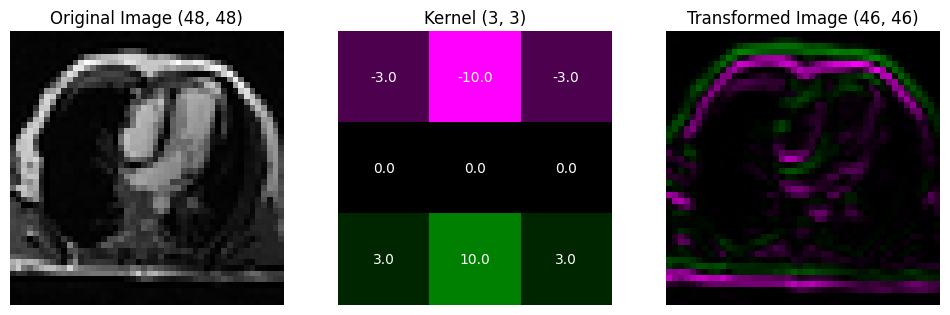


Tabular + Image + BEST Kernel MLP:
  BEST KERNEL: scharr_y
  Test RMSE:   0.0384


In [109]:


# Extract engineered features for train / test
kernel_train_feats, kernel_feature_names = extract_engineered_kernel_features(
    img_train, IMAGE_DIR, KERNEL_BANK,
    include_unsharp=True,
    include_dog=True,
    dog_params=(1.0, 2.5),
    unsharp_alpha=1.2
)

kernel_test_feats, _ = extract_engineered_kernel_features(
    img_test, IMAGE_DIR, KERNEL_BANK,
    include_unsharp=True,
    include_dog=True,
    dog_params=(1.0, 2.5),
    unsharp_alpha=1.2
)


# Pick a single sample image to visualize the convolution result consistently
# We use the same dataset_viz you already created
# Evaluate kernels and keep only the best, then visualize just that one

# Pick a single sample image to visualize the convolution result
sample_idx = 20
sample_image, _ = dataset_viz[sample_idx]  # torch tensor (1,H,W)

kernel_rmse_results = []

print(f"Baseline Tabular+Image RMSE: {rmse_comb_test:.4f}\n")

# 1) Evaluate all kernels, no plotting inside the loop
for kname, kmat in KERNEL_BANK.items():
    r = eval_single_kernel(kname, kmat,
                           img_train, img_test,
                           X_comb_train, X_comb_test,
                           y_train, y_test,
                           best_mlp_model_final, IMAGE_DIR)
    kernel_rmse_results.append((kname, r))
    print(f"Tabular+Image+{kname} RMSE: {r:.4f}  (Δ vs baseline: {rmse_comb_test - r:+.4f})")

# 2) Sort, select best, and print summary
kernel_rmse_results = sorted(kernel_rmse_results, key=lambda x: x[1])
print("\n=== Summary (lower is better) ===")
for name, r in kernel_rmse_results:
    print(f"{name:12s} -> RMSE: {r:.4f} (Δ vs baseline: {rmse_comb_test - r:+.4f})")

best_kernel_name, best_kernel_rmse = kernel_rmse_results[0]
BEST_KERNEL_NAME = best_kernel_name
BEST_KERNEL_MATRIX = KERNEL_BANK[best_kernel_name]
print(f"\n>>> BEST KERNEL: {BEST_KERNEL_NAME} (RMSE = {best_kernel_rmse:.4f})")

# 3) Visualize ONLY the best kernel convolution result
visualize_2Dconvolution(sample_image.clone(), BEST_KERNEL_MATRIX)

# 4) Build engineered features with ONLY the best kernel and update augmented sets
best_train_feats, best_feat_names = extract_engineered_kernel_features(
    img_train, IMAGE_DIR, {BEST_KERNEL_NAME: BEST_KERNEL_MATRIX},
    include_unsharp=False, include_dog=False
)
best_test_feats, _ = extract_engineered_kernel_features(
    img_test, IMAGE_DIR, {BEST_KERNEL_NAME: BEST_KERNEL_MATRIX},
    include_unsharp=False, include_dog=False
)

X_aug_train = np.hstack([X_comb_train, best_train_feats])
X_aug_test  = np.hstack([X_comb_test,  best_test_feats])

# 5) Fit an augmented MLP using only the best kernel features
augmented_mlp = clone(best_mlp_model_final)
augmented_mlp.set_params(mlp__max_iter=2000)
augmented_mlp.fit(X_aug_train, y_train)
y_pred_aug = augmented_mlp.predict(X_aug_test)
rmse_aug_test = compute_rmse(y_pred_aug, y_test)

print("\nTabular + Image + BEST Kernel MLP:")
print(f"  BEST KERNEL: {BEST_KERNEL_NAME}")
print(f"  Test RMSE:   {rmse_aug_test:.4f}")




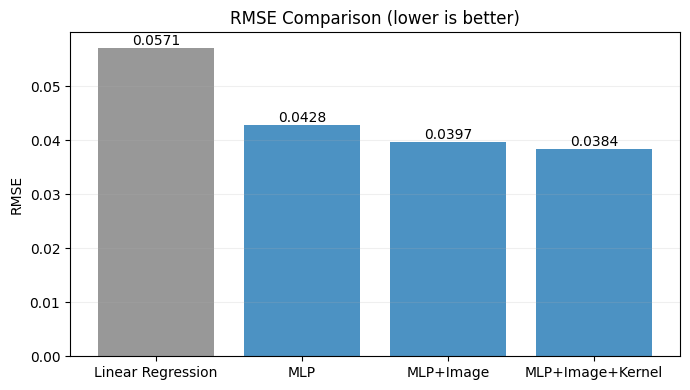

Absolute improvement MLP + Image + Kernel vs MLP: +0.0044
Absolute improvement MLP + Image + Kernel vs MLP + Image: +0.0013


In [ ]:
plot_rmse_comparison(
    {   
        "Linear Regression": rmse_test_linear,
        "MLP": rmse_tab_test,
        "MLP+Image": rmse_comb_test,
        "MLP+Image+Kernel": rmse_aug_test
    },
    title="RMSE Comparison on test set"
)

print("Absolute improvement MLP + Image + Kernel vs MLP:",
      f"{rmse_tab_test - rmse_aug_test:+.4f}")
print("Absolute improvement MLP + Image + Kernel vs MLP + Image:",
      f"{rmse_comb_test - rmse_aug_test:+.4f}")

In [112]:
y_pred_df = pd.DataFrame(y_pred_aug)
y_pred_df.to_csv("y_pred_final.csv", index=False, header=False)

print("\nFichier y_pred_final.csv généré avec succès !")


Fichier y_pred_final.csv généré avec succès !
